In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import imghdr
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from tensorflow.keras.callbacks import EarlyStopping
from PIL import ImageFile
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
from IPython.display import display, Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# train_datagen=ImageDataGenerator(featurewise_center=True, validation_split=0.06,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,preprocessing_function=preprocess_input,zoom_range=0.2,shear_range=0.2,fill_mode='nearest',brightness_range=[0.5, 1.5])
train_datagen=ImageDataGenerator(validation_split=0.06,preprocessing_function=preprocess_input)
train_data=train_datagen.flow_from_directory(directory="/kaggle/input/anyas-gojo-revival-aerospace-enigma/train",target_size=(256,256),batch_size=50,subset = 'training')
validation_data=train_datagen.flow_from_directory(directory="/kaggle/input/anyas-gojo-revival-aerospace-enigma/train",target_size=(256,256),batch_size=50,subset = 'validation')

Found 2203 images belonging to 5 classes.
Found 138 images belonging to 5 classes.


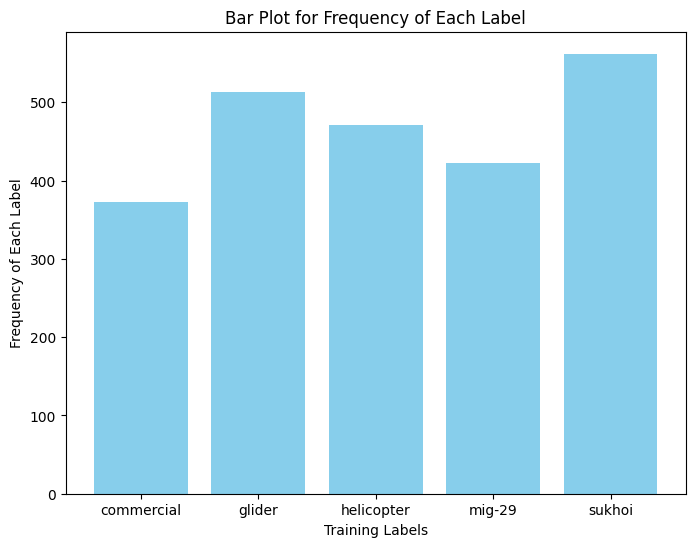

In [3]:
plt.figure(figsize=(8, 6))
plt.bar(["commercial","glider","helicopter","mig-29","sukhoi"],[len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/commercial")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/glider")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/helicopter")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/mig-29")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/sukhoi"))] , color='skyblue')
plt.xlabel('Training Labels')
plt.ylabel('Frequency of Each Label')
plt.title('Bar Plot for Frequency of Each Label')
plt.show()

In [4]:
import random
import matplotlib.image as mpimg
def view_random_images():
    random_images = []
    labels = []
    root_dir="/kaggle/input/anyas-gojo-revival-aerospace-enigma"
    for i in range(20):
        random_class = random.choice(list(train_data.class_indices.keys()))    
        random_class_path = root_dir + "/train/" + random_class
        labels.append(random_class)
        random_image = random.sample(os.listdir(random_class_path), 1)
        random_images.append(random_class_path + '/' + random_image[0])
    plt.figure(figsize=(15, 10))
    plt.suptitle("Image Dataset", fontsize=20)
    for i in range(1, 21):
        plt.subplot(5, 10, i)
        img = mpimg.imread(random_images[i-1])
        plt.imshow(img, aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False);

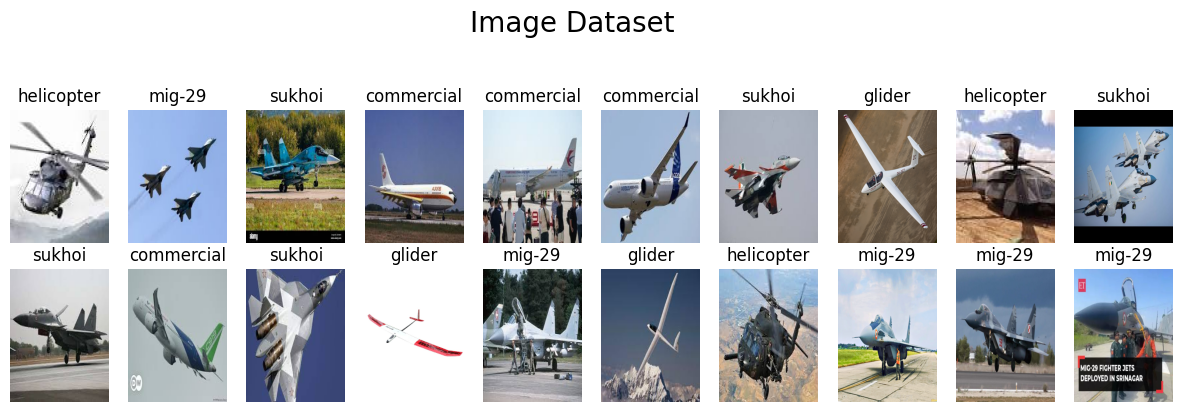

In [5]:
view_random_images()

In [6]:
base_model=InceptionV3(input_shape=(256,256,3),include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
x=layers.Flatten()(x)
x=Dense(units=5,activation='sigmoid')(x)
model=Model(base_model.input,x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
model_mobilenet_v2 = tf.keras.Sequential([
    layers.Conv2D(16,(2,2), activation="relu", padding='same',input_shape=[256, 256, 3]),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.10),
    layers.Conv2D(32,(2,2), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.10),
    layers.Conv2D(64,(2,2), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.10),
    layers.Conv2D(128,(2,2), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.10),
    layers.Conv2D(256,(2,2), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.10),
    layers.Conv2D(512,(2,2), activation="relu", padding='same'),
    layers.Flatten(),
    layers.Dense(5, activation="sigmoid", name="output_layer")                             
])
model_mobilenet_v2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [8]:
from tensorflow.keras.applications import EfficientNetB0
base_model1= EfficientNetB0(input_shape=(600,600,3),weights='imagenet', include_top=False)
for layer in base_model1.layers:
    layer.trainable=False
x=base_model1.output
x=layers.Flatten()(x)
x=Dense(units=5,activation='sigmoid')(x)
model1=Model(base_model1.input,x)
model1.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
history=model.fit(train_data,steps_per_epoch=30,epochs=30,callbacks=[early_stopping],validation_data = validation_data,validation_steps = 1)

Epoch 1/30
30/30 [==============================] - 30s 535ms/step - loss: 0.4283 - accuracy: 0.5513 - val_loss: 0.2778 - val_accuracy: 0.6800
Epoch 2/30
20/30 [===================>..........] - ETA: 3s - loss: 0.2357 - accuracy: 0.7597

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 [==============================] - 11s 351ms/step - loss: 0.2204 - accuracy: 0.7811 - val_loss: 0.2208 - val_accuracy: 0.7600
Epoch 3/30
30/30 [==============================] - 9s 308ms/step - loss: 0.1719 - accuracy: 0.8560 - val_loss: 0.2564 - val_accuracy: 0.7000
Epoch 4/30
30/30 [==============================] - 10s 315ms/step - loss: 0.1425 - accuracy: 0.8913 - val_loss: 0.2444 - val_accuracy: 0.7200
Epoch 5/30
30/30 [==============================] - 10s 321ms/step - loss: 0.1202 - accuracy: 0.9202 - val_loss: 0.1824 - val_accuracy: 0.7600
Epoch 6/30
30/30 [==============================] - 9s 288ms/step - loss: 0.0943 - accuracy: 0.9628 - val_loss: 0.2291 - val_accuracy: 0.7600
Epoch 7/30
30/30 [==============================] - 9s 301ms/step - loss: 0.0841 - accuracy: 0.9663 - val_loss: 0.2164 - val_accuracy: 0.8000
Epoch 8/30
30/30 [==============================] - 9s 314ms/step - loss: 0.0730 - accuracy: 0.9687 - val_loss: 0.1409 - val_accuracy: 0.8800
Epoch 9/30
30/

In [11]:
print(history.history)

{'loss': [0.4282906949520111, 0.22038477659225464, 0.17192557454109192, 0.14245520532131195, 0.12016552686691284, 0.09430862963199615, 0.08411123603582382, 0.0729653611779213, 0.06527427583932877, 0.05465968698263168, 0.0515885055065155, 0.04574170336127281, 0.04120561480522156, 0.036717094480991364, 0.03415969759225845, 0.03225307539105415, 0.031714361160993576], 'accuracy': [0.5513333082199097, 0.7811424732208252, 0.8560000061988831, 0.8913333415985107, 0.9201651811599731, 0.9628354907035828, 0.9662766456604004, 0.968666672706604, 0.981333315372467, 0.9886666536331177, 0.9893333315849304, 0.9926666617393494, 0.9938059449195862, 0.9972470998764038, 0.9972470998764038, 0.9972470998764038, 0.9965588450431824], 'val_loss': [0.27775487303733826, 0.22083869576454163, 0.2564278841018677, 0.2443532943725586, 0.18240460753440857, 0.22908572852611542, 0.21637748181819916, 0.1408722698688507, 0.21627257764339447, 0.1321333795785904, 0.21040135622024536, 0.1387479603290558, 0.1746574342250824, 0

In [12]:
train_data.class_indices

{'commercial': 0, 'glider': 1, 'helicopter': 2, 'mig-29': 3, 'sukhoi': 4}

In [13]:
test_path='/kaggle/input/anyas-gojo-revival-aerospace-enigma/test'
result={}
indices_dict={train_data.class_indices[i]:i for i in train_data.class_indices.keys()}
for img_path in os.listdir(test_path):
    path =os.path.join(test_path,img_path)
    img=load_img(path,target_size=(256,256))
    i=img_to_array(img)
    i=preprocess_input(i)
    pres=np.argmax(model.predict(np.array([i])))
    result.update({img_path:indices_dict[pres]})

1/1 [==============================] - 0s 26ms/step


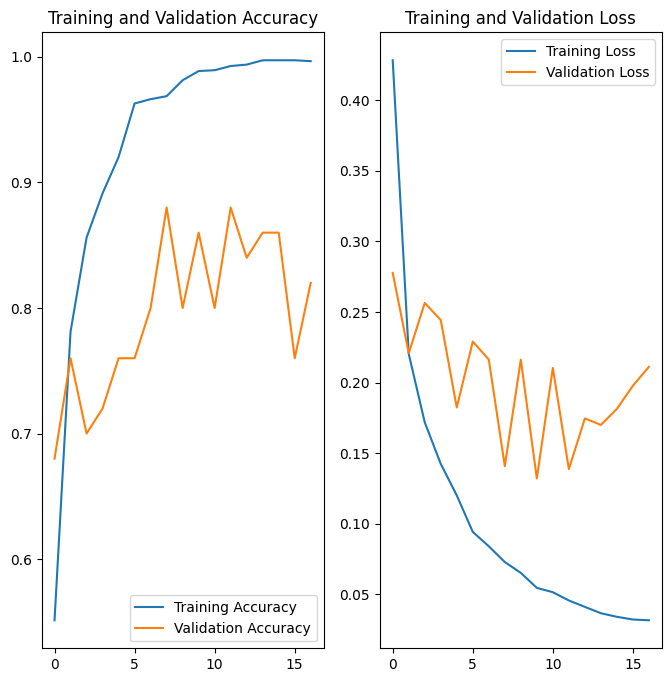

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#This code is used to plot the training and validation accuracy
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

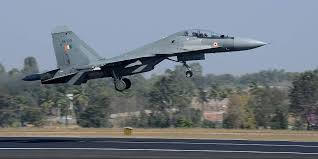

sukhoi


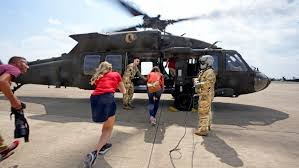

helicopter


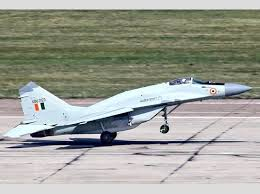

mig-29


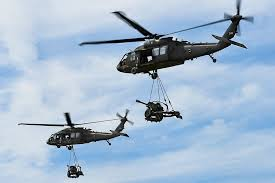

helicopter


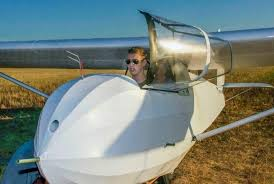

glider


In [15]:
for i in list(result.keys())[:5]:
    display(Image(os.path.join(test_path,i)))
    print(result[i])
    

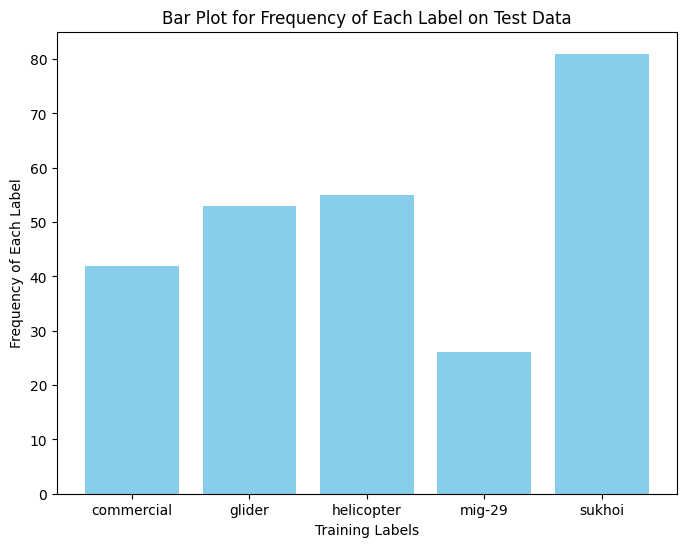

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(["commercial","glider","helicopter","mig-29","sukhoi"],[list(result.values()).count("commercial"),list(result.values()).count("glider"),list(result.values()).count("helicopter"),list(result.values()).count("mig-29"),list(result.values()).count("sukhoi")],color='skyblue')
plt.xlabel('Training Labels')
plt.ylabel('Frequency of Each Label')
plt.title('Bar Plot for Frequency of Each Label on Test Data')
plt.show()

In [17]:
import pandas as pd
submission=pd.DataFrame({'image_path':result.keys(),"Class":result.values()})
submission.to_csv("submission82.csv", index=False)